# MNIST classification with Probabilisitc Neural Network

### Import Library

In [1]:
# Pytorch Library
import torch
from torch import nn, optim
from torch.autograd import Variable

In [2]:
import torchvision.utils as utils
import torchvision.datasets as dset
import torchvision.transforms as transforms

In [3]:
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline
torch.manual_seed(777)  # reproducibility

### Prepare MNIST dataset and dataloader

In [4]:
data = dset.MNIST("./", train=True, transform=transforms.ToTensor(), download=True)
print('number of data', len(data))

number of data 60000


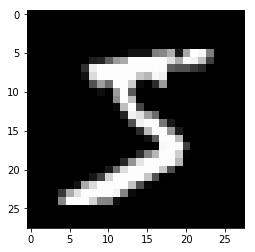

In [5]:
img, label = data[0]
#plt.figure(figsize=[6,6])
plt.imshow(img.squeeze().numpy(), cmap='gray')
plt.show()

In [6]:
batch_size = 100
data_loader = torch.utils.data.DataLoader(data,batch_size=batch_size, shuffle=True,num_workers=2)

### 1. Conventional Fully Connected (FC) Neural Network 

#### Define Model

In [7]:
input_size = 28*28
output_size = 10
hid1_size = 256
hid2_size = 128

In [8]:
class FC(nn.Module):
    def __init__(self):
        super(FC, self).__init__()
        self.fc1 = nn.Linear(input_size, hid1_size)
        self.fc2 = nn.Linear(hid1_size, hid2_size)
        self.logits = nn.Linear(hid2_size, output_size)
    def forward(self, input): # no activation function
        output = self.fc1(input)
        output = self.fc2(output)
        output = self.logits(output)
        return output
net_fc = FC()
net_fc.cuda()

FC(
  (fc1): Linear(in_features=784, out_features=256)
  (fc2): Linear(in_features=256, out_features=128)
  (logits): Linear(in_features=128, out_features=10)
)

#### Train Model

In [11]:
# Build a convinience function for reuse
def train(net):
    acc_log = []
    loss_log = []
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(net.parameters(), lr=0.001)
    max_epoch = 30
    accuracy = 0
    output_frequency = 1
    for epoch in range(max_epoch):
        for i, (images, labels) in enumerate(data_loader):

            optimizer.zero_grad()             # Zero Gradient Container

            X = Variable(images.view(-1, input_size).cuda())
            Y = Variable(labels.cuda())        # label is not one-hot encoded
            logits = net(X)           # Forward Propagation
            loss = criterion(logits, Y) # compute cost

            loss.backward()                   # compute gradient
            optimizer.step()                  # gradient update
            
            loss_log.append(loss.data[0])
            _, idx = logits.cpu().max(dim=1)
            accuracy += torch.sum(idx.view(batch_size) == Variable(labels.cpu())).data[0] / batch_size

        if epoch%output_frequency == 0:
            accuracy /= 60000/batch_size
            acc_log.append(accuracy)
            print("epoch {}, loss {}, accuracy {:6.4f}".format(epoch, loss.data[0], accuracy))
            accuracy = 0
    return acc_log, loss_log

In [12]:
acc_fc, loss_fc = train(net_fc)

epoch 0, loss 0.23764990270137787, accuracy 0.8910
epoch 1, loss 0.20993880927562714, accuracy 0.9142
epoch 2, loss 0.10892612487077713, accuracy 0.9186
epoch 3, loss 0.2929283678531647, accuracy 0.9194
epoch 4, loss 0.38611236214637756, accuracy 0.9197
epoch 5, loss 0.2568453252315521, accuracy 0.9215
epoch 6, loss 0.4023921489715576, accuracy 0.9216
epoch 7, loss 0.26787498593330383, accuracy 0.9233
epoch 8, loss 0.2672083377838135, accuracy 0.9230
epoch 9, loss 0.34409064054489136, accuracy 0.9236
epoch 10, loss 0.3652152121067047, accuracy 0.9257
epoch 11, loss 0.2711235582828522, accuracy 0.9247
epoch 12, loss 0.3827792704105377, accuracy 0.9254
epoch 13, loss 0.3943594694137573, accuracy 0.9258
epoch 14, loss 0.378579705953598, accuracy 0.9251
epoch 15, loss 0.23115089535713196, accuracy 0.9258
epoch 16, loss 0.3682751953601837, accuracy 0.9266
epoch 17, loss 0.2368089109659195, accuracy 0.9277
epoch 18, loss 0.3692678213119507, accuracy 0.9270
epoch 19, loss 0.24218688905239105,

### 2. Neural Network with Gaussian Latent Layer
Model NN(x) :

- $ a \sim P(a | \mu(x),\sigma(x))$  (x is image input)

- $ y = fc2(a) $                     (y is label)

Model NN(x) (reparameterization):

- $ a=\mu(x) + \sigma(x)*\epsilon$  where $\epsilon \sim Gaussian(0,1)$ (reparameterization)

- $ y = fc2(a) $                     (y is label)

Loss: 

- $CrossEntropy(y,fc2(a)) + KL(Gaussian(0,1) || Gaussian(\mu(x),\sigma(x)))$

In [13]:
class Gaussian(nn.Module):
    def __init__(self):
        super(Gaussian, self).__init__()
        self.fc1_mu = nn.Linear(input_size, hid1_size)
        self.fc1_sigma = nn.Linear(input_size, hid1_size)
        self.fc2 = nn.Linear(hid1_size, hid2_size)
        self.logits = nn.Linear(hid2_size, output_size)
    def forward(self, input): # no activation function
        mu = self.fc1_mu(input)
        sigma = self.fc1_sigma(input)
        noise = Variable(torch.randn(mu.size()).cuda())
        noise = mu+sigma*noise
        output = self.fc2(noise)
        output = self.logits(output)
        return output, mu, sigma, noise
net_gaussian = Gaussian()
net_gaussian.cuda()

Gaussian(
  (fc1_mu): Linear(in_features=784, out_features=256)
  (fc1_sigma): Linear(in_features=784, out_features=256)
  (fc2): Linear(in_features=256, out_features=128)
  (logits): Linear(in_features=128, out_features=10)
)

### Train Model

In [14]:
# Build a convinience function for reuse
def train(net):
    acc_log = []
    loss_log = []
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(net.parameters(), lr=0.001)
    max_epoch = 30
    accuracy = 0
    output_frequency = 1
    for epoch in range(max_epoch):
        for i, (images, labels) in enumerate(data_loader):
            optimizer.zero_grad()             # Zero Gradient Container

            X = Variable(images.view(-1, input_size).cuda())
            Y = Variable(labels.cuda())        # label is not one-hot encoded
            logits, mu, sigma, noise = net(X)  # Forward Propagation
            loss = criterion(logits, Y)        # compute cost
            loss += torch.mean(mu**2 + torch.mean(sigma**2) - torch.log(sigma**2+1e-8) - 1) # latent loss

            loss.backward()                   # compute gradient
            optimizer.step()                  # gradient update
         
            loss_log.append(loss.data[0])
            _, idx = logits.cpu().max(dim=1)
            accuracy += torch.sum(idx.view(batch_size) == Variable(labels.cpu()) ).data[0] / batch_size

        if epoch%output_frequency == 0:
            accuracy /= 60000/batch_size
            acc_log.append(accuracy)
            print("epoch {}, loss {}, accuracy {:6.4f}".format(epoch, loss.data[0], accuracy))
            accuracy = 0
    return acc_log, loss_log


In [15]:
acc_gaussian, loss_gaussian = train(net_gaussian)

epoch 0, loss 0.7934454083442688, accuracy 0.8390
epoch 1, loss 0.7169667482376099, accuracy 0.8630
epoch 2, loss 0.6467124223709106, accuracy 0.8652
epoch 3, loss 0.8012219667434692, accuracy 0.8736
epoch 4, loss 0.556667685508728, accuracy 0.8784
epoch 5, loss 0.6861320734024048, accuracy 0.8815
epoch 6, loss 0.49663400650024414, accuracy 0.8882
epoch 7, loss 0.4779479503631592, accuracy 0.8902
epoch 8, loss 0.5866430997848511, accuracy 0.8895
epoch 9, loss 0.6952852010726929, accuracy 0.8935
epoch 10, loss 0.5619927048683167, accuracy 0.8938
epoch 11, loss 0.6080739498138428, accuracy 0.8963
epoch 12, loss 0.601439356803894, accuracy 0.8977
epoch 13, loss 0.7208041548728943, accuracy 0.8988
epoch 14, loss 0.48432832956314087, accuracy 0.8987
epoch 15, loss 0.4339597225189209, accuracy 0.8997
epoch 16, loss 0.5225526094436646, accuracy 0.9020
epoch 17, loss 0.4287128448486328, accuracy 0.9012
epoch 18, loss 0.6164281368255615, accuracy 0.9015
epoch 19, loss 0.5110635161399841, accura

### 3. Zero-centered Uniform Latent Net
Model NN(x) :

- $ a \sim P(a | \mu(x),\sigma(x))$  (x is image input)

- $ y = fc2(a) $                     (y is label)

Model NN(x) (reparameterization):

- $ a=\mu(x) + \sigma(x)*\epsilon$  where $\epsilon \sim Uniform(-0.5,0.5)$ (reparameterization)

- $ y = fc2(a) $                     (y is label)

Loss: 

- $CrossEntropy(y,fc2(a)) + KL(Gaussian(0,1) || Gaussian(\mu(x),\sigma(x)))$

In [16]:
class Uniform(nn.Module):
    def __init__(self):
        super(Uniform, self).__init__()
        self.fc1_mu = nn.Linear(input_size, hid1_size)
        self.fc1_sigma = nn.Linear(input_size, hid1_size)
        self.fc2 = nn.Linear(hid1_size, hid2_size)
        self.logits = nn.Linear(hid2_size, output_size)
    def forward(self, input): # no activation function
        mu = self.fc1_mu(input)
        sigma = self.fc1_sigma(input)
        noise = Variable(torch.rand(mu.size()).cuda()-0.5)
        noise = mu+sigma*noise
        output = self.fc2(noise)
        output = self.logits(output)
        return output, mu, sigma, noise
net_uniform = Uniform()
net_uniform.cuda()

Uniform(
  (fc1_mu): Linear(in_features=784, out_features=256)
  (fc1_sigma): Linear(in_features=784, out_features=256)
  (fc2): Linear(in_features=256, out_features=128)
  (logits): Linear(in_features=128, out_features=10)
)

In [17]:
acc_uniform, loss_uniform = train(net_uniform)

epoch 0, loss 0.42039206624031067, accuracy 0.8788
epoch 1, loss 0.5532817840576172, accuracy 0.8971
epoch 2, loss 0.5004416108131409, accuracy 0.9004
epoch 3, loss 0.5124531388282776, accuracy 0.9013
epoch 4, loss 0.5139853954315186, accuracy 0.9018
epoch 5, loss 0.5096428394317627, accuracy 0.9032
epoch 6, loss 0.41284507513046265, accuracy 0.9043
epoch 7, loss 0.33282092213630676, accuracy 0.9056
epoch 8, loss 0.36382216215133667, accuracy 0.9069
epoch 9, loss 0.40997591614723206, accuracy 0.9074
epoch 10, loss 0.5212807655334473, accuracy 0.9083
epoch 11, loss 0.35169321298599243, accuracy 0.9081
epoch 12, loss 0.372749924659729, accuracy 0.9093
epoch 13, loss 0.4696681499481201, accuracy 0.9095
epoch 14, loss 0.3263701796531677, accuracy 0.9092
epoch 15, loss 0.3730491101741791, accuracy 0.9121
epoch 16, loss 0.6455100774765015, accuracy 0.9128
epoch 17, loss 0.5663498640060425, accuracy 0.9120
epoch 18, loss 0.35642945766448975, accuracy 0.9122
epoch 19, loss 0.4218711256980896, 

### Compare training loss and accuracy of 1, 2 and 3

Text(0,0.5,'loss')

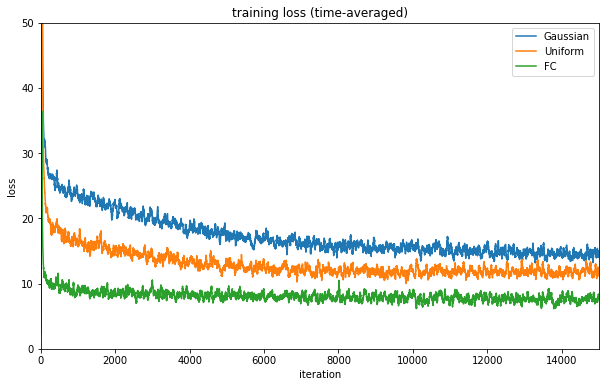

In [21]:
plt.figure(figsize=[10,6])
for loss in [loss_gaussian, loss_uniform, loss_fc]:
    plt.plot(np.convolve(loss, np.ones(30)))
plt.xlim([0,15000])
plt.ylim([0,50])
plt.legend(['Gaussian','Uniform','FC'])
plt.title('training loss (time-averaged)')
plt.xlabel('iteration')
plt.ylabel('loss')

Text(0,0.5,'accuracy')

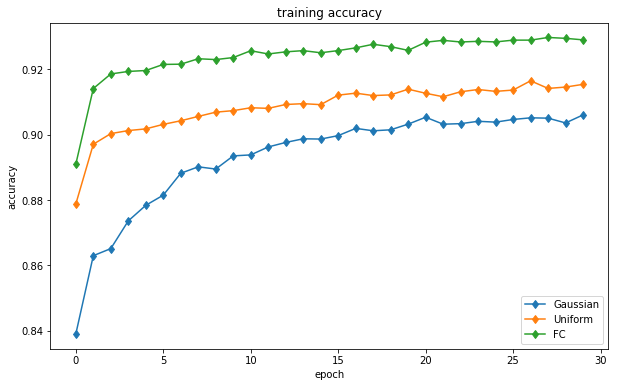

In [19]:
plt.figure(figsize=[10,6])
for acc in [acc_gaussian, acc_uniform, acc_fc]:
    plt.plot(range(30), acc,'-d')

plt.legend(['Gaussian','Uniform','FC'])
plt.title('training accuracy')
plt.xlabel('epoch')
plt.ylabel('accuracy')